In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

import ast
import warnings
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk


2025-06-16 14:36:47.174808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750084607.196873     405 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750084607.203690     405 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
warnings.filterwarnings('ignore')

# Download NLTK data for BLEU score calculation
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

In [3]:
def expand_dataset(df):
    """Combine multiple captions into one logical caption per image."""
    combined_rows = []
    i = 0

    for idx, row in df.iterrows():
        captions = row['captions']
        filepath = row['filepath']
        i = i+1
        combined_rows.append({
            'captions': captions,
            'filepath': filepath
        })

    return pd.DataFrame(combined_rows)

In [4]:
class SatelliteDataset(Dataset):
    def __init__(self, df, image_dir, transform, tokenizer, max_length=64):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length
        print(f"Dataset initialized with {len(self.df)} samples")
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, row['filepath'])
        caption = row['captions']
        
        try:
            image = Image.open(image_path).convert('RGB')
            pixel_values = self.transform(image)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a dummy image if loading fails
            image = Image.new('RGB', (224, 224), color='black')
            pixel_values = self.transform(image)
        
        tokens = self.tokenizer(
            caption,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        return {
            'pixel_values': pixel_values,
            'input_ids': tokens.input_ids.squeeze(),
            'attention_mask': tokens.attention_mask.squeeze(),
            'captions': caption
        }

In [5]:
def validate_model(model, dataloader, tokenizer, device):
    """Validate the model and return average loss"""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch in dataloader:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            
            outputs = model(pixel_values=pixel_values, labels=input_ids)
            total_loss += outputs.loss.item()
            num_batches += 1
            
            # Limit validation batches to avoid long validation time
            if num_batches >= 50:  # Validate on first 50 batches
                break
    
    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    model.train()
    return avg_loss

In [6]:
def generate_caption(model, image, tokenizer, processor, device, max_length=50):
    """Generate caption for a single image"""
    model.eval()
    with torch.no_grad():
        pixel_values = image.unsqueeze(0).to(device)
        generated_ids = model.generate(
            pixel_values=pixel_values,
            max_length=max_length,
            num_beams=4,
            early_stopping=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
        generated_caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    model.train()
    return generated_caption


In [7]:

def calculate_bleu_scores(generated_captions, reference_captions):
    """Calculate BLEU scores for generated captions"""
    smoothie = SmoothingFunction().method4
    bleu_scores = []
    
    for gen_cap, ref_cap in zip(generated_captions, reference_captions):
        # Tokenize captions
        reference = [ref_cap.lower().split()]
        candidate = gen_cap.lower().split()
        
        # Calculate BLEU score
        try:
            bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
            bleu_scores.append(bleu_score)
        except:
            bleu_scores.append(0.0)
    
    return bleu_scores
    
def evaluate_model(model, test_loader, tokenizer, device):
    """Evaluate model on test set and compute metrics including BLEU score"""
    model.eval()
    total_loss = 0
    generated_captions = []
    reference_captions = []
    num_batches = 0
    
    print("Evaluating model on test set...")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            captions = batch['captions']
            
            # Calculate loss
            outputs = model(pixel_values=pixel_values, labels=input_ids)
            total_loss += outputs.loss.item()
            
            # Generate captions for evaluation
            for i in range(pixel_values.size(0)):
                generated = generate_caption(
                    model, pixel_values[i], tokenizer, None, device
                )
                generated_captions.append(generated)
                reference_captions.append(captions[i])
            
            num_batches += 1
            
            # Print progress
            if batch_idx % 10 == 0:
                print(f"Evaluated {batch_idx + 1} batches...")
            
            # Limit evaluation to avoid very long test time
            if batch_idx >= 100:  # Evaluate on first 100 batches
                break
    
    avg_test_loss = total_loss / num_batches if num_batches > 0 else 0
    
    # Calculate BLEU scores
    bleu_scores = calculate_bleu_scores(generated_captions, reference_captions)
    avg_bleu = np.mean(bleu_scores)
    
    print("\n=== Example Predictions ===")
    for i in range(min(5, len(generated_captions))):
        print(f"Generated: {generated_captions[i]}")
        print(f"Reference: {reference_captions[i]}")
        print(f"BLEU Score: {bleu_scores[i]:.4f}")
        print("-" * 50)
    
    print(f"\nAverage BLEU Score: {avg_bleu:.4f}")
    
    return avg_test_loss, generated_captions, reference_captions, avg_bleu


In [8]:
# Load and prepare the dataset
print("Loading dataset...")
# Assuming the CSV file is named 'dataset.csv' and has columns 'filepath' and 'caption'
df = pd.read_csv('/kaggle/input/rscid-satellite-image-captioning-csv/rsicd.csv')  # Update path as needed
image_dir = '/kaggle/input/rscid-satellite-image-captioning-csv/RSICD_images/RSICD_images'  # Update path as needed

print(f"Total dataset size: {len(df)}")

# Split the dataset into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.25, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print("Dataset split sizes:")
print(f"Train: {len(train_df)}, Validation: {len(valid_df)}, Test: {len(test_df)}")

print("Loading model and tokenizer...")
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Configure tokenizer
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.eos_token_id = tokenizer.eos_token_id

# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

Loading dataset...
Total dataset size: 54605
Dataset split sizes:
Train: 40953, Validation: 6826, Test: 6826
Loading model and tokenizer...


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to

In [9]:
# Create datasets
train_dataset = SatelliteDataset(train_df, image_dir, transform, tokenizer)
valid_dataset = SatelliteDataset(valid_df, image_dir, transform, tokenizer)
test_dataset = SatelliteDataset(test_df, image_dir, transform, tokenizer)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)


Dataset initialized with 40953 samples
Dataset initialized with 6826 samples
Dataset initialized with 6826 samples
Using device: cuda


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (inte

In [10]:
class ModelSaver:
    def __init__(self, save_dir='./checkpoints'):
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        
        # Create subdirectories for different model versions
        self.best_model_dir = os.path.join(save_dir, 'best_model')
        self.checkpoints_dir = os.path.join(save_dir, 'epoch_checkpoints')
        
        os.makedirs(self.best_model_dir, exist_ok=True)
        os.makedirs(self.checkpoints_dir, exist_ok=True)
        
        # Best model tracking
        self.best_val_loss = float('inf')
        self.best_train_loss = float('inf')
        self.best_epoch = 0
        
        # Early stopping
        self.patience = 5
        self.patience_counter = 0
        self.min_delta = 1e-4
        
        # History tracking
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'epochs': []
        }
    
    def save_checkpoint(self, model, tokenizer, processor, optimizer, epoch, train_loss, val_loss, is_best=False):
        """Save model checkpoint with Hugging Face format + training info"""
        
        # Save training metadata
        training_info = {
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'best_val_loss': self.best_val_loss,
            'best_epoch': self.best_epoch,
            'history': self.history,
            'optimizer_state_dict': optimizer.state_dict()
        }
        
        # Save epoch checkpoint (Hugging Face format)
        epoch_dir = os.path.join(self.checkpoints_dir, f'epoch_{epoch}')
        os.makedirs(epoch_dir, exist_ok=True)
        
        model.save_pretrained(epoch_dir)
        tokenizer.save_pretrained(epoch_dir)
        processor.save_pretrained(epoch_dir)
        
        # Save training info separately
        training_info_path = os.path.join(epoch_dir, 'training_info.pth')
        torch.save(training_info, training_info_path)
        
        # Save best model (Hugging Face format)
        if is_best:
            model.save_pretrained(self.best_model_dir)
            tokenizer.save_pretrained(self.best_model_dir)
            processor.save_pretrained(self.best_model_dir)
            
            best_training_info_path = os.path.join(self.best_model_dir, 'training_info.pth')
            torch.save(training_info, best_training_info_path)
            
            print(f"  ✓ Best model saved! (Val Loss: {val_loss:.4f} -> {self.best_val_loss:.4f})")
            print(f"    Location: {self.best_model_dir}")
        
        return epoch_dir
    
    def should_save_best(self, val_loss):
        """Check if current model should be saved as best"""
        if val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.patience_counter = 0
            return True
        else:
            self.patience_counter += 1
            return False
    
    def should_early_stop(self):
        """Check if training should be stopped early"""
        return self.patience_counter >= self.patience
    
    def load_best_model(self, model_class, tokenizer_class, processor_class, optimizer=None):
        """Load the best saved model using Hugging Face format"""
        if os.path.exists(self.best_model_dir):
            # Load model components
            model = model_class.from_pretrained(self.best_model_dir)
            tokenizer = tokenizer_class.from_pretrained(self.best_model_dir)
            processor = processor_class.from_pretrained(self.best_model_dir)
            
            # Load training info
            training_info_path = os.path.join(self.best_model_dir, 'training_info.pth')
            training_info = torch.load(training_info_path)
            
            if optimizer is not None:
                optimizer.load_state_dict(training_info['optimizer_state_dict'])
            
            self.history = training_info['history']
            self.best_val_loss = training_info['best_val_loss']
            self.best_epoch = training_info['best_epoch']
            
            print(f"Loaded best model from epoch {training_info['epoch']} (Val Loss: {training_info['val_loss']:.4f})")
            return model, tokenizer, processor, training_info
        else:
            print("No best model found!")
            return None, None, None, None
    
    def cleanup_old_checkpoints(self, keep_last_n=3):
        """Remove old checkpoints, keeping only the last N"""
        import shutil
        
        checkpoint_dirs = [d for d in os.listdir(self.checkpoints_dir) 
                          if d.startswith('epoch_') and os.path.isdir(os.path.join(self.checkpoints_dir, d))]
        
        if len(checkpoint_dirs) > keep_last_n:
            # Sort by epoch number
            checkpoint_dirs.sort(key=lambda x: int(x.split('_')[1]))
            # Remove oldest checkpoints
            for old_checkpoint in checkpoint_dirs[:-keep_last_n]:
                old_path = os.path.join(self.checkpoints_dir, old_checkpoint)
                shutil.rmtree(old_path)
                print(f"Removed old checkpoint: {old_checkpoint}")
    
    def save_final_model(self, model, tokenizer, processor, model_name="satellite-caption-model-final"):
        """Save the final trained model in a clean format for deployment"""
        final_model_dir = os.path.join(self.save_dir, model_name)
        os.makedirs(final_model_dir, exist_ok=True)
        
        model.save_pretrained(final_model_dir)
        tokenizer.save_pretrained(final_model_dir)
        processor.save_pretrained(final_model_dir)
        
        # Save model card and training summary
        model_card = f"""
        # Satellite Image Caption Model
        
        ## Model Details
        - Best Validation Loss: {self.best_val_loss:.4f}
        - Best Epoch: {self.best_epoch}
        - Total Training Epochs: {len(self.history['epochs'])}
        
        ## Training History
        - Final Train Loss: {self.history['train_loss'][-1]:.4f}
        - Final Val Loss: {self.history['val_loss'][-1]:.4f}
        
        ## Usage
        ```python
        from transformers import VisionEncoderDecoderModel, AutoTokenizer, ViTImageProcessor
        
        model = VisionEncoderDecoderModel.from_pretrained("{final_model_dir}")
        tokenizer = AutoTokenizer.from_pretrained("{final_model_dir}")
        processor = ViTImageProcessor.from_pretrained("{final_model_dir}")
        ```
        """
        with open(os.path.join(final_model_dir, 'README.md'), 'w') as f:
            f.write(model_card)
        
        print(f"Final model saved to: {final_model_dir}")
        return final_model_dir


In [11]:
CUDA_LAUNCH_BLOCKING=1

In [12]:
# Initialize model saver and optimizer
model_saver = ModelSaver(save_dir='./model_checkpoints')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

In [13]:
model_saver = ModelSaver(save_dir='./model_checkpoints')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-4)

In [14]:
print("Starting training with enhanced model saving...")
train_losses = []
val_losses = []
num_epochs = 20


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

model.train()
start_epoch = 0

for epoch in range(start_epoch, num_epochs):
    # Training phase
    epoch_train_loss = 0
    num_train_batches = 0
    
    print(f"Epoch {epoch+1}/{num_epochs} - Training...")
    
    for batch_idx, batch in enumerate(train_loader):
        pixel_values = batch['pixel_values'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(pixel_values=pixel_values, labels=input_ids)
        loss = outputs.loss
        
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_train_loss += loss.item()
        num_train_batches += 1
        
        # Print progress every 100 batches
        if batch_idx % 100 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"  Batch {batch_idx}, Loss: {loss.item():.4f}, LR: {current_lr:.2e}")
    
    avg_train_loss = epoch_train_loss / num_train_batches
    train_losses.append(avg_train_loss)
    
    # Validation phase
    print(f"Epoch {epoch+1}/{num_epochs} - Validating...")
    val_loss = validate_model(model, valid_loader, tokenizer, device)
    val_losses.append(val_loss)
    
    # Update learning rate scheduler
    scheduler.step(val_loss)
    
    # Update model saver history
    model_saver.history['train_loss'].append(avg_train_loss)
    model_saver.history['val_loss'].append(val_loss)
    model_saver.history['epochs'].append(epoch + 1)
    
    # Check if this is the best model
    is_best = model_saver.should_save_best(val_loss)
    if is_best:
        model_saver.best_epoch = epoch + 1
    
    # Save checkpoint
    checkpoint_path = model_saver.save_checkpoint(
        model, tokenizer, processor, optimizer, epoch + 1, avg_train_loss, val_loss, is_best
    )
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Best Val Loss: {model_saver.best_val_loss:.4f} (Epoch {model_saver.best_epoch})")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
    print(f"  Patience Counter: {model_saver.patience_counter}/{model_saver.patience}")
    
    model_saver.cleanup_old_checkpoints(keep_last_n=2)
    
    # Early stopping check
    if model_saver.should_early_stop():
        print(f"\nEarly stopping triggered! No improvement for {model_saver.patience} epochs.")
        print(f"Best validation loss: {model_saver.best_val_loss:.4f} at epoch {model_saver.best_epoch}")
        break
    
    print("-" * 80)

# Load best model for testing
print("\nLoading best model for final evaluation...")
best_model, best_tokenizer, best_processor, best_checkpoint = model_saver.load_best_model(
    VisionEncoderDecoderModel, AutoTokenizer, ViTImageProcessor, optimizer
)

if best_model is not None:
    model = best_model.to(device)
    tokenizer = best_tokenizer
    processor = best_processor


final_model_path = model_saver.save_final_model(model, tokenizer, processor, "satellite-caption-model-v4")

print("Training completed!")
print(f"Final model ready for deployment at: {final_model_path}")

Starting training with enhanced model saving...
Epoch 1/20 - Training...


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


  Batch 0, Loss: 7.7599, LR: 1.00e-06
  Batch 100, Loss: 1.5738, LR: 1.00e-06
  Batch 200, Loss: 1.1523, LR: 1.00e-06
  Batch 300, Loss: 0.9534, LR: 1.00e-06
  Batch 400, Loss: 0.8452, LR: 1.00e-06
  Batch 500, Loss: 0.8211, LR: 1.00e-06
  Batch 600, Loss: 0.7568, LR: 1.00e-06
  Batch 700, Loss: 0.8368, LR: 1.00e-06
  Batch 800, Loss: 0.7179, LR: 1.00e-06
  Batch 900, Loss: 0.8360, LR: 1.00e-06
  Batch 1000, Loss: 0.7066, LR: 1.00e-06
  Batch 1100, Loss: 0.6944, LR: 1.00e-06
  Batch 1200, Loss: 0.6986, LR: 1.00e-06
Epoch 1/20 - Validating...
  ✓ Best model saved! (Val Loss: 0.6309 -> 0.6309)
    Location: ./model_checkpoints/best_model
Epoch 1/20 Summary:
  Train Loss: 0.9764
  Val Loss: 0.6309
  Best Val Loss: 0.6309 (Epoch 1)
  Learning Rate: 1.00e-06
  Patience Counter: 0/5
--------------------------------------------------------------------------------
Epoch 2/20 - Training...
  Batch 0, Loss: 0.6783, LR: 1.00e-06
  Batch 100, Loss: 0.6651, LR: 1.00e-06
  Batch 200, Loss: 0.6189, L

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to

  ✓ Best model saved! (Val Loss: 0.3783 -> 0.3783)
    Location: ./model_checkpoints/best_model
Epoch 20/20 Summary:
  Train Loss: 0.3859
  Val Loss: 0.3783
  Best Val Loss: 0.3783 (Epoch 20)
  Learning Rate: 1.00e-06
  Patience Counter: 0/5
Removed old checkpoint: epoch_18
--------------------------------------------------------------------------------

Loading best model for final evaluation...
Loaded best model from epoch 20 (Val Loss: 0.3783)
Testing and evaluating model...
Evaluating model on test set...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Evaluated 1 batches...
Evaluated 11 batches...
Evaluated 21 batches...
Evaluated 31 batches...
Evaluated 41 batches...
Evaluated 51 batches...
Evaluated 61 batches...
Evaluated 71 batches...
Evaluated 81 batches...
Evaluated 91 batches...
Evaluated 101 batches...

=== Example Predictions ===
Generated:  green and buildings around pond
Reference: there is a huge lake in the middle of the land .
BLEU Score: 0.0000
--------------------------------------------------
Generated:  cars parked a lot green .
Reference: several green trees are near a parking lot with many cars .
BLEU Score: 0.0207
--------------------------------------------------
Generated:  green and farm are two of four .
Reference: two ponds are in many pieces of green farmlands .
BLEU Score: 0.0333
--------------------------------------------------
Generated:  buildings bare and green are two of several .
Reference: many small buildings and some bareland are in two sides of a green rectangular pond .
BLEU Score: 0.0192
----

ValueError: too many values to unpack (expected 3)

In [15]:
best_checkpoint = model_saver.load_best_model(model, processor_class=processor,tokenizer_class=tokenizer,optimizer=optimizer)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to

Loaded best model from epoch 20 (Val Loss: 0.3783)


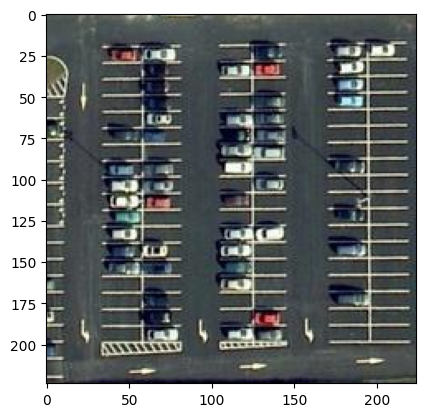

 cars parked the lot cars parked the lot


In [38]:
import matplotlib.pyplot as plt

image = Image.open('/kaggle/input/test-images-anass/parking_255.jpg').convert("RGB")
plt.imshow(image)
plt.show()

inputs = processor(images=image, return_tensors="pt").to(device)

generated_ids = model.generate(**inputs)
caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

print(caption)

In [20]:
print("\nCreating model archive...")
!zip -r satellite-caption-model-v6.zip /kaggle/working/model_checkpoints/best_model



Creating model archive...
  adding: kaggle/working/model_checkpoints/best_model/ (stored 0%)
  adding: kaggle/working/model_checkpoints/best_model/tokenizer_config.json (deflated 54%)
  adding: kaggle/working/model_checkpoints/best_model/special_tokens_map.json (deflated 60%)
  adding: kaggle/working/model_checkpoints/best_model/generation_config.json (deflated 40%)
  adding: kaggle/working/model_checkpoints/best_model/vocab.json (deflated 59%)
  adding: kaggle/working/model_checkpoints/best_model/config.json (deflated 63%)
  adding: kaggle/working/model_checkpoints/best_model/training_info.pth (deflated 8%)
  adding: kaggle/working/model_checkpoints/best_model/preprocessor_config.json (deflated 47%)
  adding: kaggle/working/model_checkpoints/best_model/tokenizer.json (deflated 82%)
  adding: kaggle/working/model_checkpoints/best_model/merges.txt (deflated 53%)
  adding: kaggle/working/model_checkpoints/best_model/model.safetensors (deflated 7%)


In [ ]:
# import shutil

# shutil.rmtree("/kaggle/working/model_checkpoints")